# DGA Sunburst Recognition with  Incremental Learning

1. [Describe the original DGA dataset (D) and the Sunburst dataset (S)](#step-1)
2. [Update the model M1 with the Sunburst train set U to get M2](#step-2)
3. [Compare M1 and M2 accuracy on the Sunburst test set T](#step-3)
4. [Compare M1 and M2 on the original DGA dataset D](#step-4)


In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from incremental_learning.config import datasets_dir, root_dir, jobs_dir
from incremental_learning.job import update, evaluate, Job, train
from incremental_learning.storage import download_dataset, download_job

In [2]:
def get_predictions(model: Job):
    probabilities = model.get_probabilities()
    predictions = np.array(list(map(lambda row: max(row, key=row.get), probabilities)))
    return predictions

## 1. Describe the original DGA dataset (D) and the Sunburst dataset (S) <a class="anchor" id="step-1"></a>

In [3]:
full_dataset_name = 'dga-data-ngrams-full'
download_dataset(full_dataset_name)
D = pd.read_csv(datasets_dir / '{}.csv'.format(full_dataset_name))
D.drop_duplicates(inplace=True)

2022-01-28 20:52:02,971 [I] incremental_learning >> File /root/data/configs/dga-data-ngrams-full.json does not exist.
2022-01-28 20:52:02,972 [I] incremental_learning >> File /root/data/datasets/dga-data-ngrams-full.csv does not exist.
2022-01-28 20:52:03,130 [I] incremental_learning >> Downloading configs/dga-data-ngrams-full.json from the Google storage bucket to /root/data/configs/dga-data-ngrams-full.json.
2022-01-28 20:52:03,292 [I] incremental_learning >> Retrieving datasets/dga-data-ngrams-full.csv from the Google storage bucket to /root/data/datasets/dga-data-ngrams-full.csv.
/root/env/lib64/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,22,23,24,25,26,27,28,29,30,31,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,1

In [4]:
dataset_name = 'dga-data-ngrams-sunburst'

download_dataset(dataset_name)
S = pd.read_csv(datasets_dir / '{}.csv'.format(dataset_name))
S.drop_duplicates(inplace=True)

2022-01-28 20:52:59,112 [I] incremental_learning >> File /root/data/configs/dga-data-ngrams-sunburst.json does not exist.
2022-01-28 20:52:59,113 [I] incremental_learning >> File /root/data/datasets/dga-data-ngrams-sunburst.csv does not exist.
2022-01-28 20:52:59,209 [I] incremental_learning >> Downloading configs/dga-data-ngrams-sunburst.json from the Google storage bucket to /root/data/configs/dga-data-ngrams-sunburst.json.
2022-01-28 20:52:59,349 [I] incremental_learning >> Retrieving datasets/dga-data-ngrams-sunburst.csv from the Google storage bucket to /root/data/datasets/dga-data-ngrams-sunburst.csv.


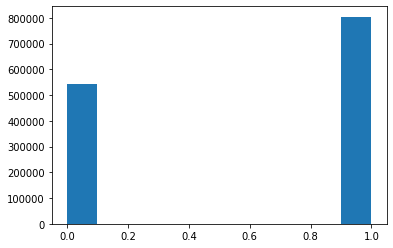

In [5]:
_ = plt.hist(D['malicious'])

The original dataset contains 1,346,626 entries with 542,484 negative benign and 804,142 malicious examples. 

Every entry has 186 features, although many of them have missing values.

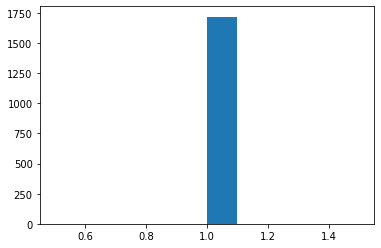

In [6]:
_ = plt.hist(S['malicious'])

The Sunburst dataset contains 1,719 malicious examples.

### Split the sunburst dataset into the update dataset (U) and the test dataset (T)

In [7]:
U, T = train_test_split(S, test_size=0.2, stratify=S['malicious'])

### Load the baseline model M1

It may take something aroung 6-7 hours to train the baseline model on the original DGA dataset. So we download a pre-trained instance of this model instead.

In [8]:
baseline_model_name = 'dga-v2-baseline-model'
download_job(baseline_model_name)
M1 = Job.from_file(source=jobs_dir / 'dga-v2-baseline-model')

# to train a job from scratch, run
# D_train, D_test = train_test_split(D, test_size=0.2, stratify=D['malicious'])
# M1 = train(dataset_name, D_train, verbose=False)

2022-01-28 20:53:00,148 [I] incremental_learning >> Downloading jobs/dga-v2-baseline-model from the Google storage bucket to /root/data/jobs/dga-v2-baseline-model.


## 2. Update the model M1 with the Sunburst train set U to get M2 <a class="anchor" id="step-2"></a>

In [9]:
hyperparameters = M1.get_hyperparameters()
del hyperparameters['retrained_tree_eta']
M2 = update(dataset_name, U, M1, verbose=False, hyperparameter_overrides=hyperparameters)
elapsed_time = M2.wait_to_complete()
print('Elapsed time {}'.format(datetime.timedelta(seconds=elapsed_time)))

Elapsed time 0:09:58.282535


Let's store the updated model in case we want to use it later.

In [10]:
M2.store(jobs_dir / 'DFA_updated')

True

## 3. Compare M1 and M2 accuracy on the Sunburst test set T <a class="anchor" id="step-3"></a>

In [14]:
eval_M1 = evaluate(dataset_name, T, M1, verbose=False)
elapsed_time = eval_M1.wait_to_complete()
print('Elapsed time {}'.format(datetime.timedelta(seconds=elapsed_time)))
y_M1 = get_predictions(eval_M1)

Elapsed time 0:04:25.933079


In [15]:
eval_M2 = evaluate(dataset_name, T, M2, verbose=False)
elapsed_time = eval_M2.wait_to_complete()
print('Elapsed time {}'.format(datetime.timedelta(seconds=elapsed_time)))
y_M2 = get_predictions(eval_M2)

Elapsed time 0:02:54.856670


In [16]:
y_true = pd.array(T[M1.dependent_variable].astype(str))

M1_accuracy = accuracy_score(y_true, y_M1)
M2_accuracy = accuracy_score(y_true, y_M2)

print("M1 accuracy:", M1_accuracy)
print("M2 accuracy:", M2_accuracy)

M1 accuracy: 0.0
M2 accuracy: 0.938953488372093


## 4. Compare M1 and M2 on the original DGA dataset D <a class="anchor" id="step-4"></a>

In [17]:
eval_M1 = evaluate(dataset_name, D, M1, verbose=False)
elapsed_time = eval_M1.wait_to_complete()
print('Elapsed time {}'.format(datetime.timedelta(seconds=elapsed_time)))
y_M1_full = get_predictions(eval_M1)

Elapsed time 0:06:34.872181


In [18]:
eval_M2 = evaluate(dataset_name, D, M2, verbose=False)
elapsed_time = eval_M2.wait_to_complete()
print('Elapsed time {}'.format(datetime.timedelta(seconds=elapsed_time)))

y_M2_full = get_predictions(eval_M2)

Elapsed time 0:06:01.817660


In [19]:
y_full_true = pd.array(D[M1.dependent_variable].astype(str))

M1_full_accuracy = accuracy_score(y_full_true, y_M1_full)
M2_full_accuracy = accuracy_score(y_full_true, y_M2_full)

print("M1 accuracy:", M1_full_accuracy)
print("M2 accuracy:", M2_full_accuracy)

M1 accuracy: 0.9870342619257314
M2 accuracy: 0.994519636484072
